In [31]:
!pip install torchinfo

In [32]:
!pip install gdown

In [33]:
import os
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
import matplotlib.pyplot as plt

In [34]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 모델 가중치 저장 경로 설정
model_weight_path = "./model_weights/LeViT_All_opt_sa.pth"

In [35]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [36]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [37]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [38]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [39]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [40]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [41]:
#CNNDownSample 적용
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [42]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [43]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [44]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x


In [45]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=100):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [46]:
model = LevitDistilled()
# model = LauncherModel()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 1e-6
num_epochs = 50

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [47]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 100]                 --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [48]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 100]                 --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [49]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [50]:
train_data = datasets.CIFAR100(root="data", train=True, transform=transform, download=True)
test_data = datasets.CIFAR100(root="data", train=False, transform=transform, download=True)
combined_data = ConcatDataset([train_data, test_data])

train_size = int(0.7 * len(combined_data))
val_size = int(0.15 * len(combined_data))
test_size = len(combined_data) - train_size - val_size
train_data, val_data, test_data = random_split(combined_data, [train_size, val_size, test_size])

Files already downloaded and verified
Files already downloaded and verified


In [51]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 42000
Validation size: 9000
Test size: 9000


In [52]:
#adamp optimization
!pip install adamp

In [53]:
from adamp import AdamP

criterion = nn.CrossEntropyLoss()
optimizer = AdamP(model.parameters(), lr=learning_rate)

In [54]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

In [55]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    if phase == "Validation":
        val_losses.append(epoch_loss)
        val_accuracies.append(accuracy)
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")

In [56]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [57]:
learning_rate = 1e-4
num_epochs = 50

optimizer = AdamP(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.56it/s]


Train Loss: 3.9464, Train Accuracy: 9.47%


Validation: 100%|██████████| 282/282 [00:15<00:00, 18.00it/s]


Validation Loss: 3.6420, Validation Accuracy: 13.76%

Epoch 2/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.66it/s]


Train Loss: 3.4767, Train Accuracy: 17.04%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.86it/s]


Validation Loss: 3.2686, Validation Accuracy: 20.51%

Epoch 3/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.61it/s]


Train Loss: 3.1611, Train Accuracy: 22.83%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 3.0132, Validation Accuracy: 25.62%

Epoch 4/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.66it/s]


Train Loss: 2.9356, Train Accuracy: 27.44%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.84it/s]


Validation Loss: 2.8603, Validation Accuracy: 28.98%

Epoch 5/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.64it/s]


Train Loss: 2.7472, Train Accuracy: 30.86%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.7590, Validation Accuracy: 30.71%

Epoch 6/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.56it/s]


Train Loss: 2.5693, Train Accuracy: 34.46%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.42it/s]


Validation Loss: 2.5435, Validation Accuracy: 35.56%

Epoch 7/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.54it/s]


Train Loss: 2.4159, Train Accuracy: 37.55%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.88it/s]


Validation Loss: 2.4515, Validation Accuracy: 36.91%

Epoch 8/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.67it/s]


Train Loss: 2.2846, Train Accuracy: 40.71%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.86it/s]


Validation Loss: 2.3942, Validation Accuracy: 38.01%

Epoch 9/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.63it/s]


Train Loss: 2.1601, Train Accuracy: 43.05%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.2918, Validation Accuracy: 40.62%

Epoch 10/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.62it/s]


Train Loss: 2.0458, Train Accuracy: 45.90%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.1960, Validation Accuracy: 42.22%

Epoch 11/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.61it/s]


Train Loss: 1.9420, Train Accuracy: 48.19%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.1737, Validation Accuracy: 43.17%

Epoch 12/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.65it/s]


Train Loss: 1.8450, Train Accuracy: 50.64%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.81it/s]


Validation Loss: 2.1244, Validation Accuracy: 44.70%

Epoch 13/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.63it/s]


Train Loss: 1.7548, Train Accuracy: 52.45%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.88it/s]


Validation Loss: 2.0828, Validation Accuracy: 45.63%

Epoch 14/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.64it/s]


Train Loss: 1.6696, Train Accuracy: 54.41%


Validation: 100%|██████████| 282/282 [00:15<00:00, 18.00it/s]


Validation Loss: 2.0619, Validation Accuracy: 46.36%

Epoch 15/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.65it/s]


Train Loss: 1.5858, Train Accuracy: 56.55%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.0347, Validation Accuracy: 47.51%

Epoch 16/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.62it/s]


Train Loss: 1.5164, Train Accuracy: 57.84%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 1.9727, Validation Accuracy: 48.62%

Epoch 17/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.65it/s]


Train Loss: 1.4459, Train Accuracy: 59.80%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.63it/s]


Validation Loss: 2.0074, Validation Accuracy: 47.92%

Epoch 18/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.64it/s]


Train Loss: 1.3739, Train Accuracy: 61.71%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 1.9656, Validation Accuracy: 48.98%

Epoch 19/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.60it/s]


Train Loss: 1.3167, Train Accuracy: 62.64%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.95it/s]


Validation Loss: 1.9641, Validation Accuracy: 49.26%

Epoch 20/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.63it/s]


Train Loss: 1.2511, Train Accuracy: 64.45%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 1.9759, Validation Accuracy: 49.51%

Epoch 21/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.64it/s]


Train Loss: 1.1928, Train Accuracy: 66.08%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.92it/s]


Validation Loss: 2.0086, Validation Accuracy: 49.84%

Epoch 22/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.63it/s]


Train Loss: 1.1292, Train Accuracy: 67.47%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.96it/s]


Validation Loss: 1.9708, Validation Accuracy: 50.28%

Epoch 23/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.61it/s]


Train Loss: 1.0853, Train Accuracy: 68.56%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.69it/s]


Validation Loss: 1.9702, Validation Accuracy: 50.51%

Epoch 24/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.65it/s]


Train Loss: 1.0325, Train Accuracy: 70.07%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 1.9819, Validation Accuracy: 50.07%

Epoch 25/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.62it/s]


Train Loss: 0.9785, Train Accuracy: 71.40%


Validation: 100%|██████████| 282/282 [00:15<00:00, 18.06it/s]


Validation Loss: 1.9716, Validation Accuracy: 51.13%

Epoch 26/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.62it/s]


Train Loss: 0.9337, Train Accuracy: 72.51%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.0094, Validation Accuracy: 50.06%

Epoch 27/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.65it/s]


Train Loss: 0.8839, Train Accuracy: 73.96%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.84it/s]


Validation Loss: 2.0242, Validation Accuracy: 50.82%

Epoch 28/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.66it/s]


Train Loss: 0.8386, Train Accuracy: 75.28%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.86it/s]


Validation Loss: 2.0437, Validation Accuracy: 50.61%

Epoch 29/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.66it/s]


Train Loss: 0.7999, Train Accuracy: 76.19%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.0768, Validation Accuracy: 50.94%

Epoch 30/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.64it/s]


Train Loss: 0.7613, Train Accuracy: 77.30%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.0607, Validation Accuracy: 51.13%

Epoch 31/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.63it/s]


Train Loss: 0.7236, Train Accuracy: 78.15%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.90it/s]


Validation Loss: 2.0929, Validation Accuracy: 50.77%

Epoch 32/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.63it/s]


Train Loss: 0.6882, Train Accuracy: 79.39%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.0739, Validation Accuracy: 51.23%

Epoch 33/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.63it/s]


Train Loss: 0.6484, Train Accuracy: 80.35%


Validation: 100%|██████████| 282/282 [00:15<00:00, 18.03it/s]


Validation Loss: 2.1730, Validation Accuracy: 50.73%

Epoch 34/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.63it/s]


Train Loss: 0.6192, Train Accuracy: 81.18%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.96it/s]


Validation Loss: 2.1723, Validation Accuracy: 51.22%

Epoch 35/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.59it/s]


Train Loss: 0.5921, Train Accuracy: 81.95%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.1756, Validation Accuracy: 51.07%

Epoch 36/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.63it/s]


Train Loss: 0.5587, Train Accuracy: 83.01%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 2.1986, Validation Accuracy: 51.32%

Epoch 37/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.61it/s]


Train Loss: 0.5380, Train Accuracy: 83.56%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.2037, Validation Accuracy: 51.63%

Epoch 38/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.55it/s]


Train Loss: 0.5213, Train Accuracy: 83.99%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.85it/s]


Validation Loss: 2.2305, Validation Accuracy: 51.33%

Epoch 39/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.62it/s]


Train Loss: 0.4897, Train Accuracy: 84.85%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.96it/s]


Validation Loss: 2.2357, Validation Accuracy: 51.29%

Epoch 40/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.60it/s]


Train Loss: 0.4669, Train Accuracy: 85.58%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.75it/s]


Validation Loss: 2.2478, Validation Accuracy: 52.37%

Epoch 41/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.64it/s]


Train Loss: 0.4540, Train Accuracy: 85.77%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.2879, Validation Accuracy: 51.20%

Epoch 42/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.62it/s]


Train Loss: 0.4396, Train Accuracy: 86.22%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.91it/s]


Validation Loss: 2.3112, Validation Accuracy: 51.11%

Epoch 43/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.61it/s]


Train Loss: 0.4170, Train Accuracy: 86.91%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.3462, Validation Accuracy: 50.93%

Epoch 44/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.62it/s]


Train Loss: 0.3995, Train Accuracy: 87.65%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.81it/s]


Validation Loss: 2.4166, Validation Accuracy: 50.10%

Epoch 45/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.65it/s]


Train Loss: 0.3870, Train Accuracy: 87.72%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.64it/s]


Validation Loss: 2.4560, Validation Accuracy: 50.48%

Epoch 46/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.61it/s]


Train Loss: 0.3783, Train Accuracy: 88.19%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.3867, Validation Accuracy: 51.64%

Epoch 47/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.60it/s]


Train Loss: 0.3534, Train Accuracy: 88.98%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.3659, Validation Accuracy: 52.37%

Epoch 48/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.65it/s]


Train Loss: 0.3418, Train Accuracy: 89.15%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.93it/s]


Validation Loss: 2.4108, Validation Accuracy: 51.44%

Epoch 49/50


Training: 100%|██████████| 1313/1313 [01:52<00:00, 11.62it/s]


Train Loss: 0.3447, Train Accuracy: 89.11%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.82it/s]


Validation Loss: 2.4440, Validation Accuracy: 51.69%

Epoch 50/50


Training: 100%|██████████| 1313/1313 [01:53<00:00, 11.56it/s]


Train Loss: 0.3179, Train Accuracy: 89.97%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]

Validation Loss: 2.4272, Validation Accuracy: 51.54%


In [58]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 282/282 [00:16<00:00, 17.06it/s]

Test Loss: 2.4170, Test Accuracy: 50.87%


In [60]:
os.makedirs(os.path.dirname(model_weight_path), exist_ok=True)
torch.save(model.state_dict(), model_weight_path)
print(f"Model weights saved to {model_weight_path}")

Model weights saved to ./model_weights/LeViT_All_opt_sa.pth


In [61]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 282
Average Time: 5.80 ms
Standard Deviation: 0.48 ms
Maximum Time: 10.38 ms
Minimum Time: 5.47 ms


In [62]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.00%     313.440us        21.30%       3.340ms     139.184us       0.000us         0.00%       2.548ms     106.181us            24  
                                           aten::linear         0.59%      92.315us        16.42%       2.576ms     143.099us       0.000us         0.00%       1.841ms     102.267us            18  
         

NameError: name 'log_dir' is not defined

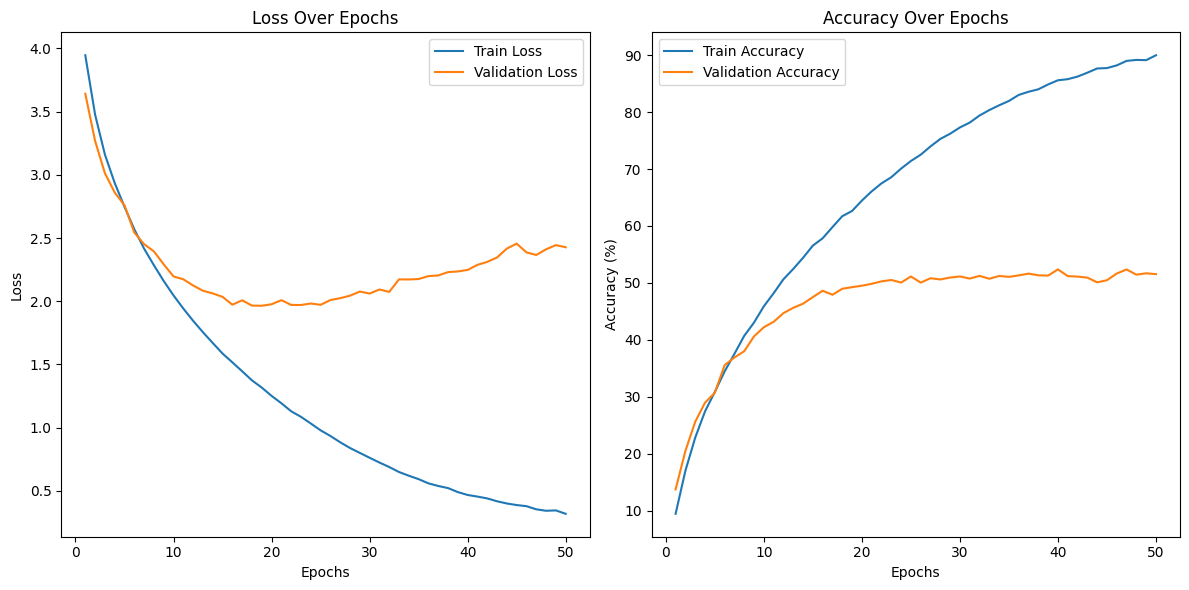

In [63]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(log_dir, "training_results.png"))
plt.show()